<a href="https://www.kaggle.com/code/lorenzojayd/elo-system-in-formula-1?scriptVersionId=172321559" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
Among the premier sports leagues in the world, Formula 1 stands unique due to a certain dynamic. Due to the structure of Formula 1's championship, a competitor/driver's teammate is his/her first and foremost competition and opponent. This special dynamic leads to a different way in which its competitors are assessed and ranked against all other competitors in its history. That is; that the drivers are most often compared against their teammates than against their opponents from other teams. 

The main objective of this experiment is to quantify a driver's performance against his/her teammates by applying a variation of the  **ELo rating system** famously used in chess, and to identify the drivers that performed best against their teammates.


# Importing libraries and data
source: Ergast - http://ergast.com/mrd/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ergast-database-image/races.csv
/kaggle/input/ergast-database-image/drivers.csv
/kaggle/input/ergast-database-image/constructors.csv
/kaggle/input/ergast-database-image/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship

In [2]:
data_constructors = pd.read_csv('/kaggle/input/ergast-database-image/constructors.csv')
data_races = pd.read_csv('/kaggle/input/ergast-database-image/races.csv')
data_results = pd.read_csv('/kaggle/input/ergast-database-image/results.csv')
data_drivers = pd.read_csv('/kaggle/input/ergast-database-image/drivers.csv')

# Data Pre-processing

In [3]:
features_races = ['raceId', 'year', 'round', 'name']
features_drivers = ['driverId', 'driverRef', 'code', 'forename', 'surname']
features_constructors = ['constructorId', 'constructorRef', 'name']

# Merging the results data with the other relevant datasets to obtain the required values from placeholder IDs.
df_master = pd.merge(data_results, data_races[features_races], how = 'left', on = 'raceId')
df_master = df_master.merge(data_drivers[features_drivers], how = 'left', on = 'driverId')
df_master = df_master.merge(data_constructors[features_constructors], how = 'left', on = 'constructorId')

df_master['race_yearAndName'] = df_master['year'].astype(str) + ' ' + df_master['name_x']

features_master = ['resultId', 'year', 'round', 'name_x', 'raceId', 'race_yearAndName', 'driverRef', 'forename', 'surname', 'constructorRef', 'name_y', 'positionOrder', 'position']
df_master = df_master[features_master].rename(columns = {'name_x': 'race_name',
                                                         'year': 'race_year',
                                                         'round': 'race_round',
                                                         'forename': 'driver_firstName',
                                                         'surname': 'driver_lastName', 
                                                         'name_y': 'constructor_name'})

df_master = df_master.sort_values(by = ['race_year', 'race_round'], ascending = True).reset_index(drop = True)
df_master['elo'] = None

# Final master dataframe:
df_master.head(2)


,resultId,race_year,race_round,race_name,raceId,race_yearAndName,driverRef,driver_firstName,driver_lastName,constructorRef,constructor_name,positionOrder,position,elo
0,20025,1950,1,British Grand Prix,833,1950 British Grand Prix,farina,Nino,Farina,alfa,Alfa Romeo,1,1,None
1,20026,1950,1,British Grand Prix,833,1950 British Grand Prix,fagioli,Luigi,Fagioli,alfa,Alfa Romeo,2,2,None


In [4]:
# Checking for null values and datatypes of each feature
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26359 entries, 0 to 26358
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   resultId          26359 non-null  int64 
 1   race_year         26359 non-null  int64 
 2   race_round        26359 non-null  int64 
 3   race_name         26359 non-null  object
 4   raceId            26359 non-null  int64 
 5   race_yearAndName  26359 non-null  object
 6   driverRef         26359 non-null  object
 7   driver_firstName  26359 non-null  object
 8   driver_lastName   26359 non-null  object
 9   constructorRef    26359 non-null  object
 10  constructor_name  26359 non-null  object
 11  positionOrder     26359 non-null  int64 
 12  position          26359 non-null  object
 13  elo               0 non-null      object
dtypes: int64(5), object(9)
memory usage: 2.8+ MB


# Exploratory Data Analysis

In [5]:
def plotDriverToRaceRatio(df):
    df_yearly = df[['race_year']].drop_duplicates(subset = 'race_year').reset_index(drop = True)
    df_driversPerRace = pd.DataFrame({
    'race_yearAndName': df['race_yearAndName'].unique().astype(str),
    'count': 0
    })

    for i, year in df_yearly.iterrows():
        count_drivers = df[df['race_year'] == year['race_year']]['driverRef'].nunique()
        df_yearly.loc[i, 'count_drivers'] = count_drivers

        count_races = df[df['race_year'] == year['race_year']]['race_round'].max()
        df_yearly.loc[i, 'count_races'] = count_races

    for i, race in df_driversPerRace.iterrows():
        count = df[df['race_yearAndName'] == race['race_yearAndName']]['driverRef'].nunique()
        df_driversPerRace.loc[i, 'count'] = count
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, gridspec_kw = {'width_ratios': [1, 7]}, figsize = (16, 9))
    fig.tight_layout(pad = 3)

    sns.boxplot(data = df_yearly, y = 'count_drivers', ax = ax1)
    ax1.set_ylim(0, 120)
    ax1.set_ylabel('Number of drivers')

    sns.barplot(data = df_yearly, x = 'race_year', y = 'count_drivers', ax = ax2)
    ax2.set_xticks(range(0, 71, 5))
    ax2.set_ylim(0, 120)
    ax2.set_ylabel('Number of drivers')
    ax2.set_xlabel('Year')

    sns.boxplot(data = df_yearly, y = 'count_races', ax = ax3)
    ax3.set_ylim(0, 30)
    ax3.set_ylabel('Number of races')

    sns.barplot(data = df_yearly, x = 'race_year', y = 'count_races', ax = ax4)
    ax4.set_xticks(range(0, 71, 5))
    ax4.set_ylim(0, 30)
    ax4.set_ylabel('Number of races')
    ax4.set_xlabel('Year')

    sns.boxplot(data = df_driversPerRace, y = 'count', ax = ax5)
    ax5.set_ylim(0, 50)
    ax5.set_ylabel('Number of drivers')

    sns.scatterplot(data = df_driversPerRace, x = 'race_yearAndName', y = 'count', ax = ax6)
    ax6.set_xticks(range(0, 1100, 200))
    ax6.set_ylim(0, 50)
    ax6.set_ylabel('Number of Drivers')
    ax6.set_xlabel('Race')

    fig.suptitle('Driver-Race ratio over time')

    plt.show(fig)

    return df_yearly, df_driversPerRace

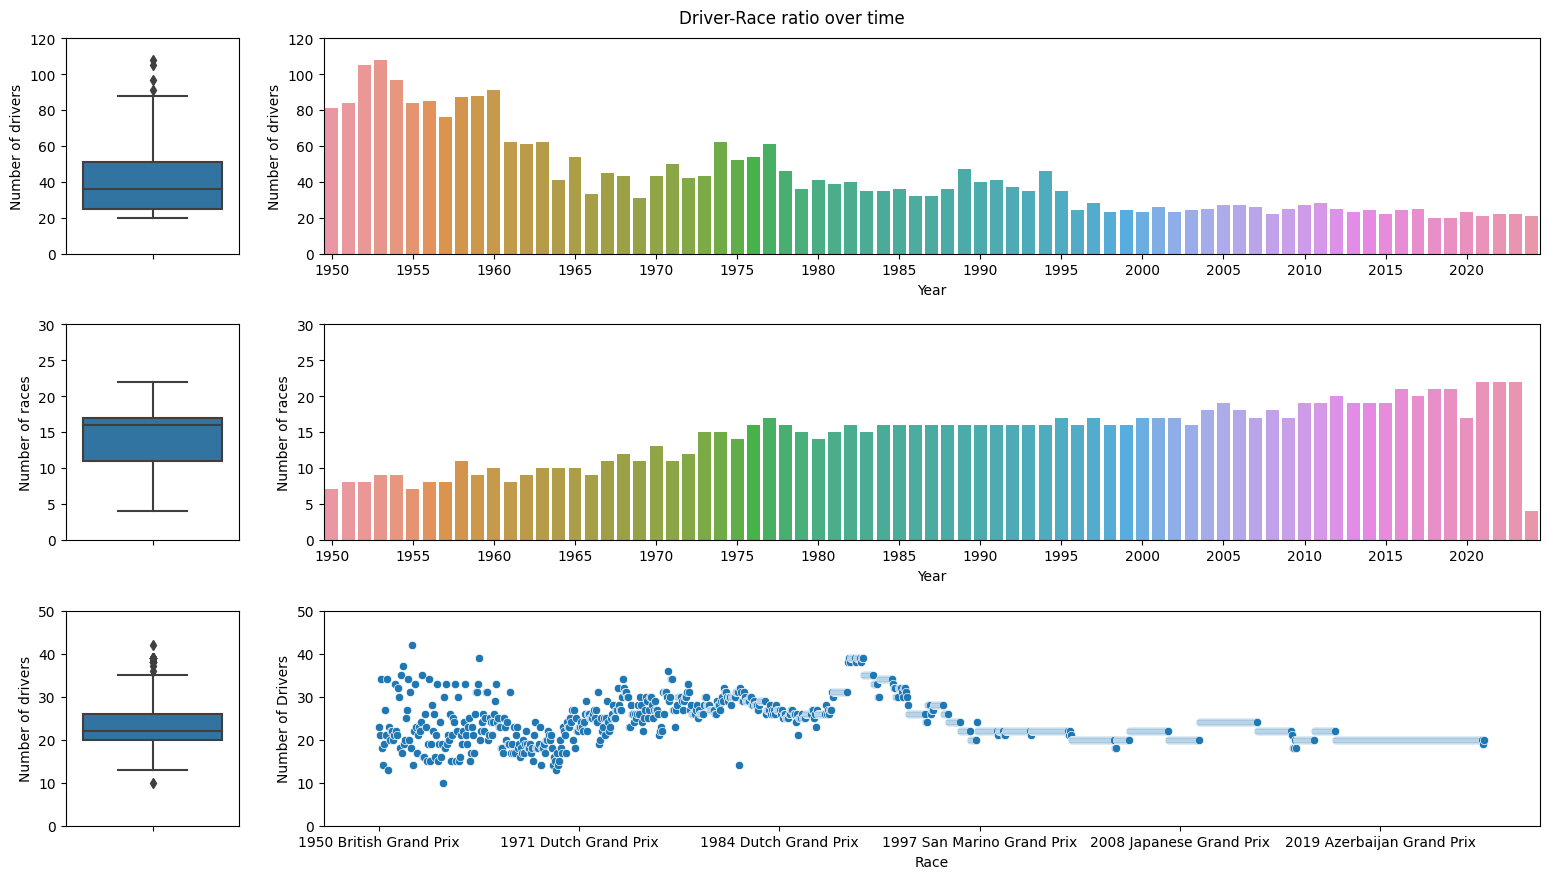

In [6]:
df_yearly, df_driversPerRace = plotDriverToRaceRatio(df_master)

From the figure above, an imbalance between the number of races and number of drivers over time is observed. We can see that in the early years of the championship, the number of participants in each race varies widely race-to-race. We can see that as the championship matured, the number of partipants in each race has become uniform. This is due to looser regulations and qualification requirements, and Formula 1 hosting more varied types of races such as the Indianapolis 500 where teams fielded more drivers and cars than usual. This will create a potentially skewed result.

## Addressing the outliers

In [7]:
indy = df_driversPerRace[df_driversPerRace['race_yearAndName'].str.contains('Indianapolis 500')]
indy

,race_yearAndName,count
2,1950 Indianapolis 500,34
8,1951 Indianapolis 500,34
16,1952 Indianapolis 500,33
24,1953 Indianapolis 500,37
33,1954 Indianapolis 500,42
43,1955 Indianapolis 500,35
50,1956 Indianapolis 500,34
58,1957 Indianapolis 500,33
67,1958 Indianapolis 500,33
76,1959 Indianapolis 500,33


It is observed that among the grands prix that have a high amount of driver participation, the Indianapolis 500 held in 1950 to 1960 consistently had driver participation upwards of 33 drivers per race. Although the Indianapolis 500 was historically part of the F1 championship during these years, F1 regulars didn't participate and constructors championship points (from 1958 onwards) weren't awarded to the event's finishers, hence the non-participation of regular F1 drivers and the participation of non-regular F1 drivers. This also creates a skewed result in the F1 elo system as the high number of teammates will cause certain drivers' elo ratings to skyrocket due to their high number of teammates.

For the purposes of this experiment, Indianapolis 500 events will be excluded altogether.

# Elo System
- $R'_A = R_A + K(S_A - E_A)$
    - where:
        - $R'$ - New rating
        - $R$ - Old rating
        - $K$ - Scaling factor ($K$ = 32)
            - K indicates the maximum amount of Elo rating that a driver may gain or lose.
        - $S$ - Actual outcome
        - $E$ - Expected outcome

- $E_A = \frac{Q_A}{(Q_A + Q_B)}$
- $Q_A = 10^{\frac{R_A}{c}}$
    - where:
        - $c$ = 400

In [8]:
class F1Elo:
    def __init__(self, df_main):
        self.df_main = df_main
        self.df_elo = pd.DataFrame({
            'driverRef': self.df_main['driverRef'].unique(),
            'running_elo': 1000,
            'pre_race_elo': 1000,
        })
        self.df_result_con = None
        self.df_result_res = None

    def computeExpectedOutcome(self, elo_a = None, elo_b = None):
        # Computes the expected outcome given the elo ratings of driver A and driver B.
        if elo_a is None or elo_b is None:
            raise Exception('Elo of driver A or B is invalid')
        
        c = 400 # 
        q_a = 10 ** (elo_a / c)
        q_b = 10 ** (elo_b / c)
        expectedOutcome = q_a / (q_a + q_b)

        return expectedOutcome

    def computeActualOutcome(self, positionOrder_a = None, positionOrder_b = None):
        # Computes the actual outcome given the finishing positions of driver A and driver B.
        # Returns 1 if driver A finishes in a higher position (lower number) than driver B. Returns 0 otherwise.
        if positionOrder_a is None or positionOrder_b is None:
            raise Exception('Position of driver A or B is invalid')
        
        if positionOrder_a < positionOrder_b:
            actualOutcome = 1
        else:
            actualOutcome = 0
        
        return actualOutcome

    def computeEloGain(self, expectedOutcome = None, actualOutcome = None):
        # Returns the elo rating that is gained by a driver given the expected outcome and actual outcome.
        # The k value determines the maximum points that a driver can gain or lose.
        if expectedOutcome is None:
            raise Exception('Expected outcome is invalid')
        elif actualOutcome is None:
            raise Exception('Actual outcome is invalid')

        k = 32
        gain = k * (actualOutcome - expectedOutcome)

        return gain

    def getElo(self, driverRef = None):
        # Queries a master elo dataframe to obtain the driver's pre-race elo.
        if driverRef is None or driverRef == '':
            raise Exception('No driver input')
        
        df_elo = self.df_elo
        elo = df_elo[df_elo['driverRef'] == driverRef]['pre_race_elo']
        elo = elo.reset_index(drop = True)

        if elo is None:
            raise Exception('Driver not found')
        
        return elo[0]
    
    def getTeammates(self, driverRef_a, current_raceId, current_constructorRef):
        # Returns the driver's teammate/s in the race
        df_main = self.df_main
        df_teammates = df_main[(df_main['raceId'] == current_raceId) & (df_main['constructorRef'] == current_constructorRef) & (df_main['driverRef'] != driverRef_a)]
        df_teammates = df_teammates.reset_index(drop = True)

        return df_teammates
    
    def updateRunningElo(self, driverRef, newElo):
        # Updates the running elo which stores the drivers' new calculated elo after the race.
        df_elo_update = self.df_elo
        df_elo_update.loc[df_elo_update['driverRef'] == driverRef, 'running_elo'] = newElo
        self.df_elo = df_elo_update
    
    def updatePreRaceElo(self):
        # Updates the pre-race elo before the start of the next race.
        # The reason behind the the two elo ratings (running elo and pre-race elo) is because while iterating over the drivers' results, 
        # the getElo function should return the pre-race elo instead of the driver's calculated new elo (running elo).
        df_elo_update_all = self.df_elo
        df_elo_update_all['pre_race_elo'] = df_elo_update_all['running_elo']
        self.df_elo = df_elo_update_all

    def updateMain(self, raceId, driverRef, newElo):
        # Adds a driver's elo at a given event
        df_main = self.df_main
        df_main.loc[(df_main['raceId'] == raceId) & (df_main['driverRef'] == driverRef), 'elo'] = newElo
        self.df_main = df_main
    
    def resetElo(self):
        # Resets the elo rating to 1000 at the start of every year/season
        df_elo = self.df_elo
        df_elo['pre_race_elo'] = 1000
        df_elo['running_elo'] = 1000
    
    def runElo(self):
        # Executes the elo system
        df_main = self.df_main
        previous_raceId = df_main.loc[0, 'raceId']

        for i, data in df_main.iterrows():
            current_raceId = data['raceId']
            current_race_yearAndName = data['race_yearAndName']
            current_constructorRef = data['constructorRef']

            # update pre-race elo if the loop has moved to the next race
            if previous_raceId != current_raceId:
                self.updatePreRaceElo()
                previous_raceId = current_raceId

            # driver A results:
            driverRef_a = data['driverRef']
            positionClass_a = data['position']
            positionOrder_a = data['positionOrder']
            elo_a = self.getElo(driverRef_a)

            # The driver only gains or loses elo if he/she classifies as having finished the race
            if positionClass_a != '\\N':
                # iterate over teammates
                df_teammates = self.getTeammates(driverRef_a, current_raceId, current_constructorRef)
                eloGain = 0
                for t, teammate in df_teammates.iterrows():
                    # driver B results:
                    driverRef_b = teammate['driverRef']
                    positionClass_b = teammate['position']
                    positionOrder_b = teammate['positionOrder']
                    elo_b = self.getElo(driverRef_b)
                    
                    # the driver only gains or loses elo if his/her teammate also classifies as having finished the race
                    if positionClass_b != '\\N':
                        expectedOutcome = self.computeExpectedOutcome(elo_a, elo_b)
                        actualOutcome = self.computeActualOutcome(positionOrder_a, positionOrder_b)
                        eloGain += self.computeEloGain(expectedOutcome, actualOutcome)
                newElo_a = round(elo_a + eloGain)
            else:
                newElo_a = elo_a
            # update running elo
            self.updateRunningElo(driverRef_a, newElo_a)

            # update main dataframe
            self.updateMain(current_raceId, driverRef_a, newElo_a)
        # update pre-race elo for the last/latest race    
        self.updatePreRaceElo()
        self.df_main = df_main

        self.resetElo()
    
    def history(self):
        return self.df_main

## Analysis Tools

In [9]:
def getTopDrivers(df):
    df_top = df.sort_values(by = 'elo', ascending = False).drop_duplicates(subset = 'driverRef')
    df_top = df_top.drop(columns = ['race_name', 'resultId', 'race_year', 'race_round', 'raceId', 'driverRef', 'constructorRef', 'positionOrder']).reset_index(drop = True)
    df_top.rename(columns = {
        'driver_firstName': 'Driver First Name',
        'driver_lastName': 'Driver Last Name',
        'constructor_name': 'Constructor',
        'race_yearAndName': 'Race Achieved',
        'elo': 'Elo'
    }, inplace = True)
    df_top['position'] = df_top.index + 1
    df_top = df_top.set_index('position', drop = True)
    return df_top

def plotYearlyDistribution(df):
    sns.set_theme(style = 'white', rc = {'axes.facecolor': (0, 0, 0, 0), 'axes.linewidth':2})
    pal = sns.cubehelix_palette(10, rot = -.25, light = .7)

    g = sns.FacetGrid(df, palette = pal, row = 'race_year', hue = 'race_year', aspect = 15, height = .5)
    
    g.map(sns.kdeplot, 'elo', bw_adjust = .5, clip_on = False, fill = True, alpha = 1, linewidth = 1.5)

    g.refline(y = 0, linewidth = 2, linestyle = '-', color = None, clip_on = False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .1, label, fontweight = 'bold', color = color, fontsize = 13, ha = 'left', va = 'center', transform = ax.transAxes)

    g.map(label, 'elo')
    g.figure.subplots_adjust(hspace = -0.35)
    
    g.set_titles('')
    g.set(yticks = [], xlabel = 'Elo Rating', ylabel = '')
    g.despine(left = True, bottom = True)

def plotDriverVsTeammates(df, driverRef):
    driver_firstName = df[df['driverRef'] == driverRef]['driver_firstName'].iloc[0]
    driver_lastName = df[df['driverRef'] == driverRef]['driver_lastName'].iloc[0]
    df_driverRaces = df[df['driverRef'] == driverRef].reset_index(drop = True)
    df_driverVsTeammate = pd.DataFrame({
        'race': df_driverRaces['race_yearAndName'].values,
        'driver': driverRef,
        'teammate': None,
        'driver_elo': None,
        'teammate_elo': None,
    })

    for i, race in df_driverRaces.iterrows():
        current_constructorRef = race['constructorRef']
        current_race_yearAndName = race['race_yearAndName']
        df_driverVsTeammate.loc[df_driverVsTeammate['race'] == race['race_yearAndName'], 'driver_elo'] = race['elo']

        teammate = df[(df['race_yearAndName'] == current_race_yearAndName) & (df['constructorRef'] == current_constructorRef) & (df['driverRef'] != driverRef)].reset_index(drop = True).iloc[0]
        df_driverVsTeammate.loc[df_driverVsTeammate['race'] == teammate['race_yearAndName'], 'teammate'] = teammate['driverRef']
        df_driverVsTeammate.loc[df_driverVsTeammate['race'] == teammate['race_yearAndName'], 'teammate_elo'] = teammate['elo']

    fig = plt.figure(figsize = (20, 6))
    fig = sns.lineplot(data = df_driverVsTeammate, x = 'race', y = 'driver_elo', color = 'black')
    fig = sns.lineplot(data = df_driverVsTeammate, x = 'race', y = 'teammate_elo', hue = 'teammate')
    fig.set_ylim(800, 1500)
    length = len(df_driverRaces)
    fig.set_xticks(range(0, length, length // 4))
    fig.tick_params('both', length = 10, width = 2, which = 'major')
    fig.set_ylabel('Elo Rating')
    fig.set_xlabel('Race')
    fig.set_title("{0} {1}'s Elo rating over time".format(driver_firstName, driver_lastName))
    legend = plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
    frame = legend.get_frame()
    frame.set_facecolor('white')

# Results

In [10]:
# Exclude the Indianapolis 500 events from the input
df_cleaned = df_master[df_master['race_name'] != 'Indianapolis 500']

f1 = F1Elo(df_cleaned)
f1.runElo()
history = f1.history()

## Top 30 Drivers by peak Elo rating achieved

In [11]:
getTopDrivers(history).head(30)

,Race Achieved,Driver First Name,Driver Last Name,Constructor,Elo
position,,,,,
1,2015 Belgian Grand Prix,Fernando,Alonso,McLaren,1475
2,1958 French Grand Prix,Juan,Fangio,Maserati,1409
3,1954 Italian Grand Prix,Alberto,Ascari,Ferrari,1385
4,2024 Japanese Grand Prix,Max,Verstappen,Red Bull,1360
5,2006 German Grand Prix,Michael,Schumacher,Ferrari,1325
6,2016 Italian Grand Prix,Jenson,Button,McLaren,1318
7,2013 Brazilian Grand Prix,Sebastian,Vettel,Red Bull,1312
8,1991 Monaco Grand Prix,Ayrton,Senna,McLaren,1310
9,2023 Las Vegas Grand Prix,Lewis,Hamilton,Mercedes,1308


### The top driver's Elo rating gain breakdown

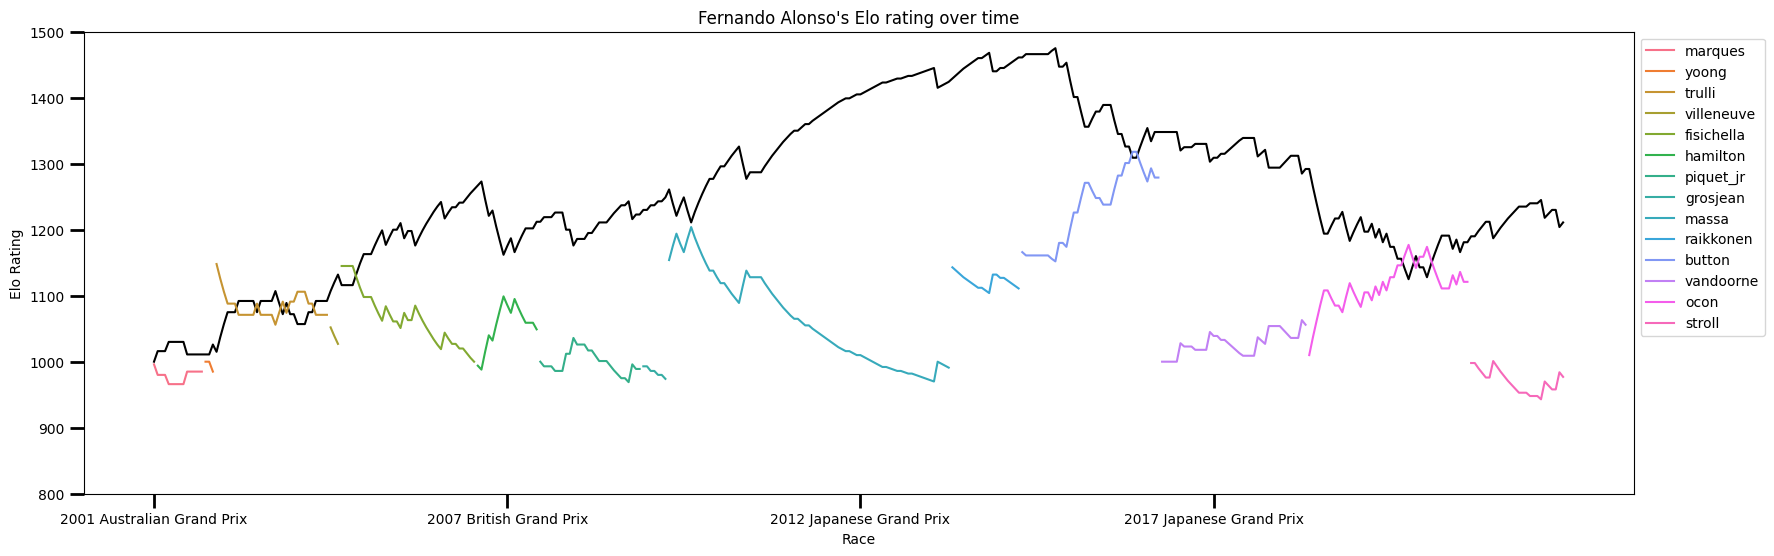

In [12]:
plotDriverVsTeammates(history, 'alonso')

## Bonus: Yearly distribution of Elo ratings

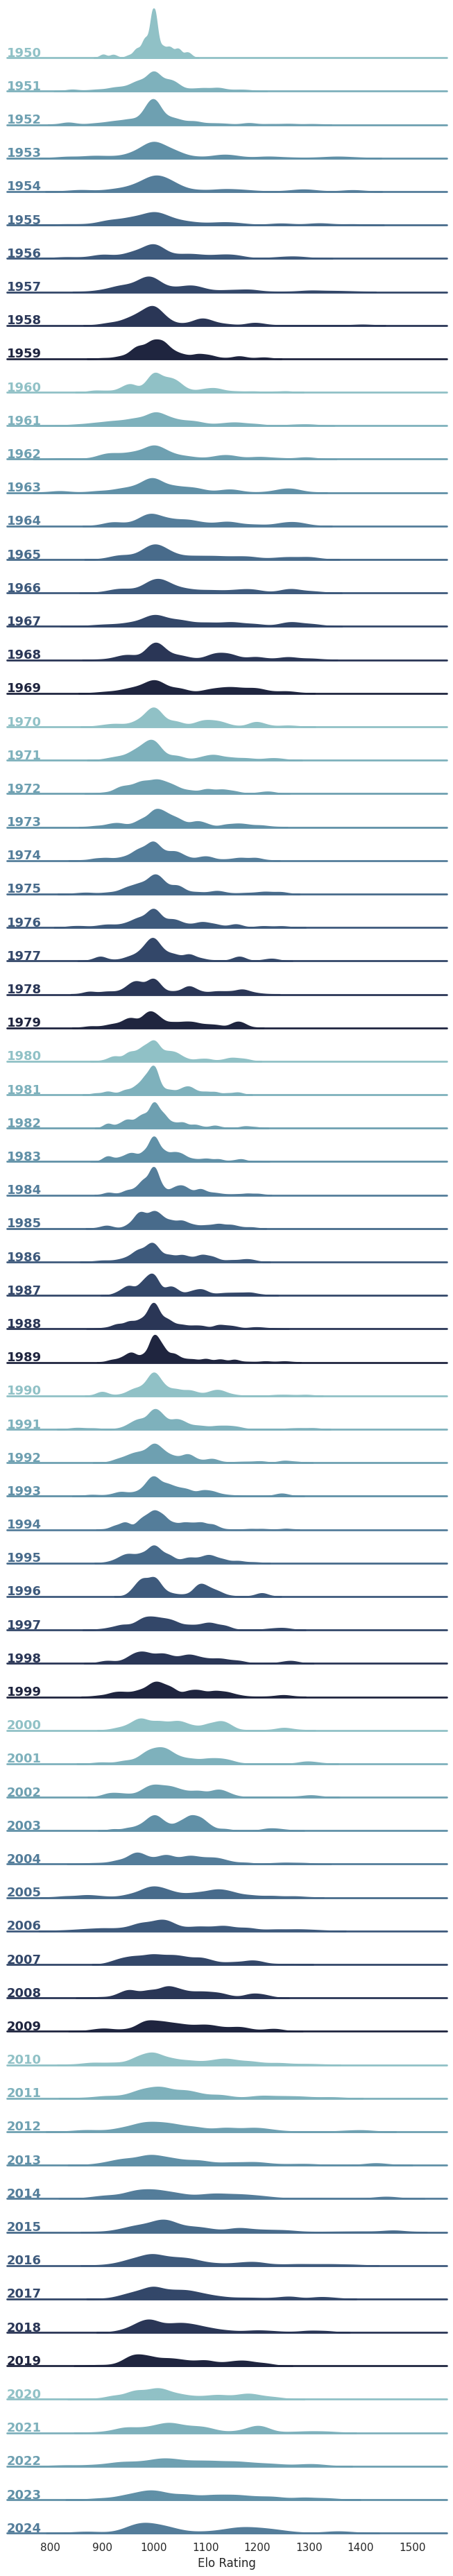

In [13]:
plotYearlyDistribution(history)